In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Parquet EDA") \
    .getOrCreate()

24/05/16 14:43:21 WARN Utils: Your hostname, seons-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.25.172.131 instead (on interface en0)
24/05/16 14:43:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/16 14:43:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
parquet_directory = "/Users/seonminhwang/Downloads/yellow_tripdata_2024-01.parquet"
df = spark.read.parquet(parquet_directory)

In [3]:
df

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double]

## Step 1. Preprocessing

- Remove rows with any missing values (na.drop).- 
Compute Trip Duration: Add a new column to calculate the trip duration in seconds by subtracting the pickup time from the dropoff time
- Filter Invalid Durations: Remove trips with non-positive durations.s.

In [4]:
from pyspark.sql.functions import col, unix_timestamp

# Data cleaning and preparation
df_cleaned = df.na.drop()

# Add a column for trip duration in seconds
df_cleaned = df_cleaned.withColumn("trip_duration", 
                                   (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")))

# Filter out trips with invalid durations
df_cleaned = df_cleaned.filter(col("trip_duration") > 0)

## Step 2: Feature Selection

- Select Features: Extract relevant features for anomaly detection.- 
Vector Assembler: Use VectorAssembler to combine the selected features into a single vector column named features.

In [5]:
# Select relevant features for analysis
features_df = df_cleaned.select("trip_duration", "trip_distance", "fare_amount", "total_amount", "tip_amount", "tolls_amount", "congestion_surcharge", "airport_fee")

# Assemble features into a vector
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=features_df.columns, outputCol="features")
vector_df = assembler.transform(features_df)

## Step 3. PCA/Spectral Analysis

- Apply PCA: Reduce the dimensionality of the feature space by applying PCA to the features column.
- The result is a new DataFrame with a pca_features column containing the principal components.
- 
Show PCA Results: Display the transformed features (principal components).

In [6]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Summarizer

# Apply PCA
pca = PCA(k=3, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(vector_df)
pca_result = pca_model.transform(vector_df)

# Show PCA results
pca_result.select("pca_features").show(truncate=False)

24/05/16 14:43:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/16 14:43:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/05/16 14:43:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+-------------------------------------------------------------+
|pca_features                                                 |
+-------------------------------------------------------------+
|[-1188.0928235326426,-24.403295325457577,-2.5811511297034087]|
|[-396.07138977086663,-19.769360605216416,-1.3599362485334496]|
|[-1075.1311763460742,-35.55630950746277,-1.1652663740579685] |
|[-498.06539626212776,-17.84952562419442,-1.5367570652989466] |
|[-366.0592080162913,-16.351994975058986,-1.8449171847132484] |
|[-1943.1678745733077,-44.571947010624925,-2.9976458538945434]|
|[-1563.2723123973706,-75.02536527516047,-1.11805952713401]   |
|[-1680.1278819766164,-33.51066095473422,-2.9226244935073793] |
|[-1691.1563543271575,-41.57229142101836,-1.66357094643467]   |
|[-68.02743151198405,-7.762550139949549,-1.1662452304279116]  |
|[-379.0496959555954,-13.550097682931202,-1.4868628315509878] |
|[-543.0945197405484,-26.11104426552091,-2.9947907921389216]  |
|[-2196.351810741188,-96.75106574589513,

## Step 4: Anomaly Detection
- Compute PCA Norm: Define and register a UDF to calculate the Euclidean norm of PCA features, then add this norm as a new column (pca_norm) in the DataFrame.
- Calculate Statistics: Compute summary statistics (mean and standard deviation) for the pca_norm column.
- Set Anomaly Threshold: Define an anomaly threshold as the mean plus three times the standard deviation of pca_norm.
- Identify and Show Anomalies: Filter the DataFrame for rows where pca_norm exceeds the threshold and display these anomalies.

In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors

# Define a UDF to compute the norm (Euclidean distance) of the PCA features
def pca_norm(pca_vector):
    return float(Vectors.norm(pca_vector, 2))

norm_udf = udf(pca_norm, DoubleType())

# Add a column for the norm of the PCA features
pca_result = pca_result.withColumn("pca_norm", norm_udf(col("pca_features")))

# Calculate mean and standard deviation of PCA norms using describe
error_stats = pca_result.select("pca_norm").describe().toPandas()

# Extract mean and std values
mean_norm = float(error_stats[error_stats['summary'] == 'mean']['pca_norm'].iloc[0])
std_norm = float(error_stats[error_stats['summary'] == 'stddev']['pca_norm'].iloc[0])

# Define a threshold for anomalies (e.g., mean + 3 * std)
threshold = mean_norm + 3 * std_norm

# Label anomalies
anomalies = pca_result.filter(col("pca_norm") > threshold)

# Show anomalies
anomalies.show(truncate=False)

24/05/16 14:43:33 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------------+-------------+-----------+------------+----------+------------+--------------------+-----------+--------------------------------------------+-----------------------------------------------------------+-----------------+
|trip_duration|trip_distance|fare_amount|total_amount|tip_amount|tolls_amount|congestion_surcharge|airport_fee|features                                    |pca_features                                               |pca_norm         |
+-------------+-------------+-----------+------------+----------+------------+--------------------+-----------+--------------------------------------------+-----------------------------------------------------------+-----------------+
|86108        |2.75         |17.7       |28.38       |5.68      |0.0         |2.5                 |0.0        |[86108.0,2.75,17.7,28.38,5.68,0.0,2.5,0.0]  |[-86107.58775961242,268.32854823910685,-5.901645531652209] |86108.00604368083|
|85969        |4.9          |33.1       |49.53       |11.43 

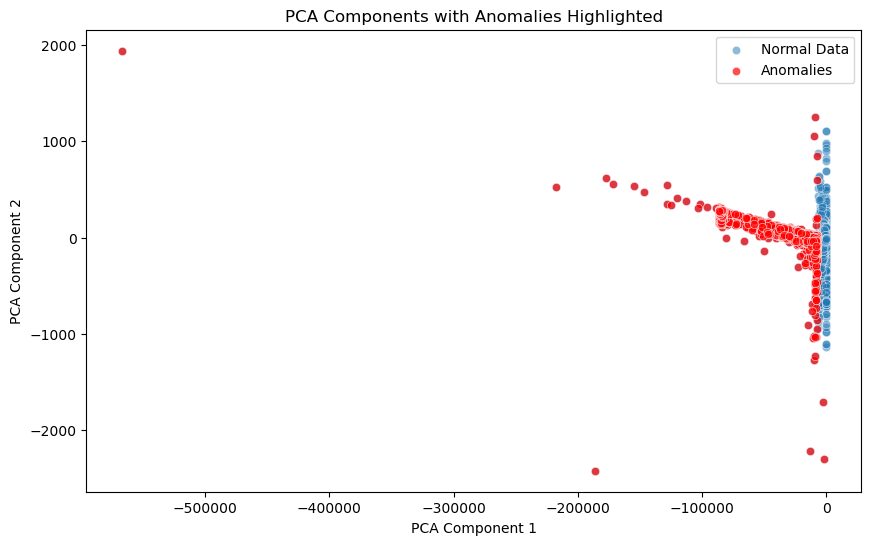

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spark DataFrame to a Pandas DataFrame
pca_result_pd = pca_result.select("pca_features", "pca_norm").toPandas()
anomalies_pd = anomalies.select("pca_features", "pca_norm").toPandas()

# Extract PCA components for plotting
pca_components = pd.DataFrame(pca_result_pd["pca_features"].values.tolist(), columns=["PCA1", "PCA2", "PCA3"])
anomaly_components = pd.DataFrame(anomalies_pd["pca_features"].values.tolist(), columns=["PCA1", "PCA2", "PCA3"])

# Add the pca_norm to the components DataFrame
pca_components["pca_norm"] = pca_result_pd["pca_norm"]
anomaly_components["pca_norm"] = anomalies_pd["pca_norm"]

# Plot the first two PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", data=pca_components, label="Normal Data", alpha=0.5)
sns.scatterplot(x="PCA1", y="PCA2", data=anomaly_components, label="Anomalies", color="red", alpha=0.7)
plt.title("PCA Components with Anomalies Highlighted")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [9]:
# Extract normal data (excluding anomalies)
normal_data = pca_result.filter(col("pca_norm") <= threshold).select("trip_duration", "trip_distance", "fare_amount", "total_amount", "tip_amount", "tolls_amount", "congestion_surcharge", "airport_fee")
normal_data_pd = normal_data.toPandas()
anomalies_pd = anomalies.select("trip_duration", "trip_distance", "fare_amount", "total_amount", "tip_amount", "tolls_amount", "congestion_surcharge", "airport_fee").toPandas()

# Calculate summary statistics for normal and anomalous data
normal_summary = normal_data_pd.describe()
anomalies_summary = anomalies_pd.describe()

print("Summary Statistics for Normal Data:")
print(normal_summary)

print("\nSummary Statistics for Anomalous Data:")
print(anomalies_summary)

Summary Statistics for Normal Data:
       trip_duration  trip_distance   fare_amount  total_amount    tip_amount  \
count   2.821055e+06   2.821055e+06  2.821055e+06  2.821055e+06  2.821055e+06   
mean    8.848941e+02   3.240007e+00  1.805609e+01  2.682452e+01  3.426071e+00   
std     7.073857e+02   4.595700e+00  1.833938e+01  2.301787e+01  3.914795e+00   
min     1.000000e+00   0.000000e+00 -8.000000e+02 -8.010000e+02 -8.000000e+01   
25%     4.240000e+02   1.000000e+00  8.600000e+00  1.530000e+01  1.000000e+00   
50%     6.900000e+02   1.670000e+00  1.280000e+01  2.000000e+01  2.800000e+00   
75%     1.113000e+03   3.100000e+00  1.980000e+01  2.850000e+01  4.200000e+00   
max     7.349000e+03   1.715220e+03  8.200000e+02  8.210000e+02  4.280000e+02   

       tolls_amount  congestion_surcharge   airport_fee  
count  2.821055e+06          2.821055e+06  2.821055e+06  
mean   5.346751e-01          2.256805e+00  1.410841e-01  
std    2.141064e+00          8.225141e-01  4.875100e-01  
mi